#BoundingBox
- 바운딩 박스 찾기 -> 회귀 작업

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
!gdown https://drive.google.com/uc?id=1-RBvPOYycsSpS7rVP0Pqwcbh18lZYDeb

Downloading...
From: https://drive.google.com/uc?id=1-RBvPOYycsSpS7rVP0Pqwcbh18lZYDeb
To: /content/BBRegression.zip
100% 945k/945k [00:00<00:00, 208MB/s]


In [3]:
!unzip /content/BBRegression.zip

Archive:  /content/BBRegression.zip
   creating: BBRegression/
  inflating: BBRegression/README.dataset.txt  
  inflating: BBRegression/README.roboflow.txt  
   creating: BBRegression/test/
  inflating: BBRegression/test/cat-110_jpg.rf.919d96206faca75068ac5595928f4005.jpg  
  inflating: BBRegression/test/cat-110_jpg.rf.919d96206faca75068ac5595928f4005.xml  
  inflating: BBRegression/test/cat-123_jpg.rf.9a0878d7d6e110b302293109a66b43bf.jpg  
  inflating: BBRegression/test/cat-123_jpg.rf.9a0878d7d6e110b302293109a66b43bf.xml  
  inflating: BBRegression/test/cat-143_jpg.rf.61045dbe235b78c5fdf8d2267b0bea85.jpg  
  inflating: BBRegression/test/cat-143_jpg.rf.61045dbe235b78c5fdf8d2267b0bea85.xml  
  inflating: BBRegression/test/cat-144_jpg.rf.50b4b01d0df37d977b1341837708aa1d.jpg  
  inflating: BBRegression/test/cat-144_jpg.rf.50b4b01d0df37d977b1341837708aa1d.xml  
  inflating: BBRegression/test/cat-188_jpg.rf.4bb417309154766edeac39c9c9d083f7.jpg  
  inflating: BBRegression/test/cat-188_jpg.rf

In [4]:
# XML에서 바운딩 좌표 정보를 읽어오는 함수
import glob
import xml.etree.ElementTree as ET

# 함수 가져오기

def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):

        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            bbx = member.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = member.find('name').text

            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [5]:
Image_path = '/content/BBRegression'

In [6]:
import os

FileName = 'label_cats.csv'
csv_path = os.path.join(Image_path,'train')
xml_df = xml_to_csv(csv_path)
xml_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,cat-193_jpg.rf.0011b0901f709dad9f2017f2a3a3c1a...,224,224,cat,30,15,205,156
1,cat-280_jpg.rf.7f896ee30db7572742bb1d9d4faa8e5...,224,224,cat,6,10,66,79
2,cat-28_jpg.rf.27a874e0fa79267b8311563cde71394a...,224,224,cat,59,28,215,178
3,cat-13_jpg.rf.9a221a3efdcd6ed55aa1d0f2326af6d7...,224,224,cat,5,5,119,171
4,cat-127_jpg.rf.3ba0e31044319a31a94b28134a30793...,224,224,cat,59,54,187,213


In [7]:
xml_df.to_csv(FileName)

In [8]:
images = xml_df.iloc[:,0].values #파일 이름

In [9]:
points = xml_df.iloc[:,4:].values

In [10]:
#시각화
import PIL

dataset_img = []
dataset_bbs = []

for file,point in zip(images,points):
  f = os.path.join(Image_path,'train',file)
  image = PIL.Image.open(f)
  arr = np.array(image)
  dataset_img.append(arr)
  dataset_bbs.append(point)


In [11]:
dataset_img = np.array(dataset_img)
dataset_bbs = np.array(dataset_bbs)

In [12]:
dataset_img.shape

(91, 224, 224, 3)

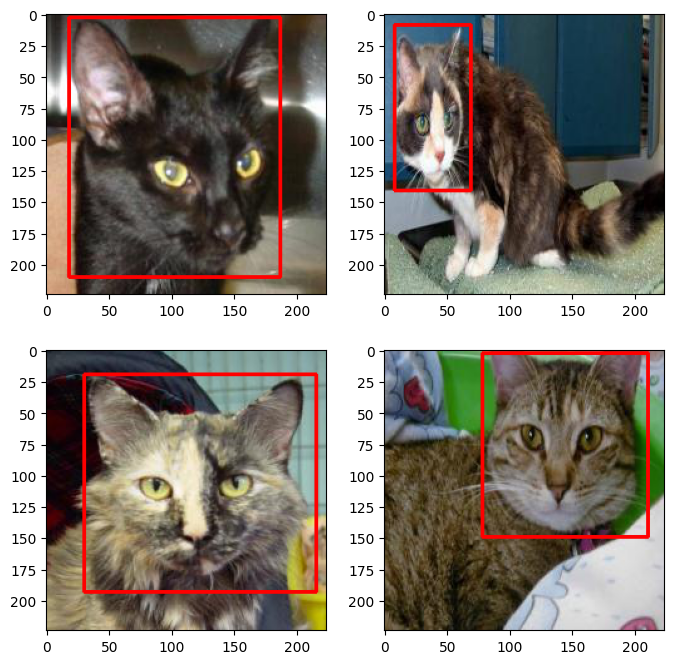

In [13]:
import cv2

samples = np.random.randint(91, size=4)

plt.figure(figsize=(8, 8))
for i, idx in enumerate(samples):
    points = dataset_bbs[idx].reshape(2, 2)
    img = cv2.rectangle(dataset_img[idx].copy(),
                        tuple(points[0]),
                        tuple(points[1]),
                        color=(255, 0, 0),
                        thickness=2)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(dataset_img, dataset_bbs, test_size = 0.2)

In [15]:
X_train.shape, Y_train.shape

((72, 224, 224, 3), (72, 4))

In [16]:
X_train = X_train / 255.
X_val = X_val / 255.

In [17]:
Y_train = Y_train.astype('float32')
Y_val = Y_val.astype('float32')

In [18]:
from keras.applications import MobileNetV2

In [19]:
base = MobileNetV2(
    include_top = False,
    weights = 'imagenet', #디폴트값
    input_shape = (224, 224, 3)
 )

base.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

In [20]:
from tensorflow import keras
from keras import layers

model = keras.Sequential([
    base,
    layers.Flatten(),
    layers.Dense(units = 32, activation = 'relu'),
    layers.Dense(units = 16, activation = 'relu'),
    layers.Dense(units = 4)
])

In [21]:
model.compile(
    optimizer = 'adam',
    loss = 'mse',
    metrics = 'mse'
)

In [22]:
from keras.callbacks import ModelCheckpoint

ckpt_path = './ckpt/cats_bbs.ckpt'
ckpt = ModelCheckpoint(
    ckpt_path,
    save_weighys_only =True,
    save_best_only = True,
    verbose = 1
)

In [23]:
X_train.shape

(72, 224, 224, 3)

In [25]:
history = model.fit(
    X_train, Y_train,
    epochs = 50,
    batch_size = 16,
    callbacks = [ckpt],
    validation_data = (X_val, Y_val),
    verbose = 1
)

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 6027.9570 - mse: 6027.9570
Epoch 1: val_loss improved from inf to 2617.32935, saving model to ./ckpt/cats_bbs.ckpt


5/5 [==============================] - 69s 7s/step - loss: 6027.9570 - mse: 6027.9570 - val_loss: 2617.3293 - val_mse: 2617.3293
Epoch 2/50
4/5 [=======================>......] - ETA: 0s - loss: 2883.4175 - mse: 2883.4175
Epoch 2: val_loss did not improve from 2617.32935
5/5 [==============================] - 0s 94ms/step - loss: 2845.9316 - mse: 2845.9316 - val_loss: 5056.1240 - val_mse: 5056.1240
Epoch 3/50
4/5 [=======================>......] - ETA: 0s - loss: 1850.0541 - mse: 1850.0541
Epoch 3: val_loss did not improve from 2617.32935
5/5 [==============================] - 0s 81ms/step - loss: 1840.2346 - mse: 1840.2346 - val_loss: 62766.0938 - val_mse: 62766.0938
Epoch 4/50
4/5 [=======================>......] - ETA: 0s - loss: 1548.3192 - mse: 1548.3192
Epoch 4: val_loss did not improve from 2617.32935
5/5 [==============================] - 0s 77ms/step - loss: 1559.6578 - mse: 1559.6578 - val_loss: 185249.6406 - val_mse: 185249.6406
Epoch 5/50
4/5 [=======================>......

In [26]:
model.load_weights(ckpt_path)

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 32)                2007072   
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
Total params: 4,265,652
Trainable params: 4,231,540
Non-trainable params: 34,112
_________________________________________

In [27]:
model.save('model_dir')

In [28]:
#케라스로 저장
model.save('cats_bbs.h5')

In [30]:
#모델 로딩
from keras.models import load_model

new_model = load_model('cats_bbs.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 32)                2007072   
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
Total params: 4,265,652
Trainable params: 4,231,540
Non-trainable params: 34,112
_________________________________________

In [32]:
#테스트/데이터 로딩
fnames = glob.glob('/content/BBRegression/test' + '/*.jpg')
X_test = []
for f in fnames:
    image = PIL.Image.open(f)
    arr = np.array(image)
    X_test.append(arr)
X_test = np.array(X_test)
X_test = X_test.astype('float32')/255.
y_pred = model.predict(X_test).astype('int')

1/1 [==============================] - 2s 2s/step


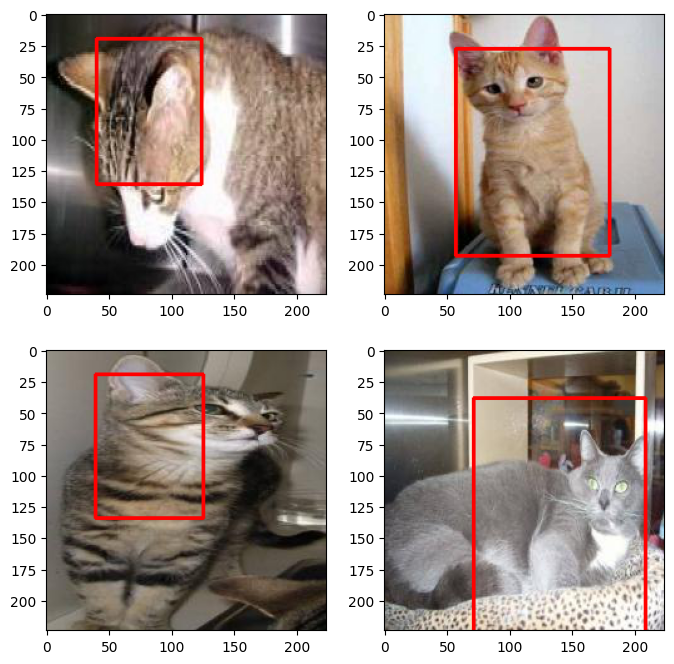

In [33]:
samples = np.random.randint(11, size=4)
plt.figure(figsize=(8, 8))
for i, idx in enumerate(samples):
    points = y_pred[idx].reshape(2, 2)
    img = cv2.rectangle(X_test[idx].copy(), tuple(points[0]),tuple(points[1]),color=(255, 0, 0),
                        thickness=2)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
plt.show()